# Bank Fears Loanliness

Problem Statement

The Bank Indessa has not done well in last 3 quarters. Their NPAs (Non Performing Assets) have reached all time high. It is starting to lose confidence of its investors. As a result, it’s stock has fallen by 20% in the previous quarter alone.

After careful analysis, it was found that the majority of NPA was contributed by loan defaulters. With the messy data collected over all the years, this bank has decided to use machine learning to figure out a way to find these defaulters and devise a plan to reduce them.

This bank uses a pool of investors to sanction their loans. For example: If any customer has applied for a loan of $20000, along with bank, the investors perform a due diligence on the requested loan application. Keep this in mind while understanding data.

In this challenge, you will help this bank by predicting the probability that a member will default.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## Preparing Training Dataset

In [0]:
data=pd.read_csv("/content/drive/My Drive/My Projects/898ce544-0-MLChallenge_1Datac63af4e (1)/train_indessa.csv")

In [11]:
data.shape

(532428, 45)

In [12]:
data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,batch_enrolled,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,verification_status_joint,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_status
0,58189336,14350,14350,14350.0,36 months,,19.19,E,E3,clerk,9 years,OWN,28700.0,Source Verified,n,NaN,debt_consolidation,Debt consolidation,349xx,FL,33.88,0.0,1.0,50.0,75.0,14.0,1.0,22515.0,73.1,28.0,f,1173.84,0.0,0.0,0.0,0.0,74.0,INDIVIDUAL,NaN,26th week,0.0,0.0,28699.0,30800.0,0
1,70011223,4800,4800,4800.0,36 months,BAT1586599,10.99,B,B4,Human Resources Specialist,< 1 year,MORTGAGE,65000.0,Source Verified,n,NaN,home_improvement,Home improvement,209xx,MD,3.64,0.0,1.0,NaN,NaN,6.0,0.0,7624.0,23.2,13.0,w,83.95,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,0.0,9974.0,32900.0,0
2,70255675,10000,10000,10000.0,36 months,BAT1586599,7.26,A,A4,Driver,2 years,OWN,45000.0,Not Verified,n,NaN,debt_consolidation,Debt consolidation,447xx,OH,18.42,0.0,0.0,NaN,NaN,5.0,0.0,10877.0,31.2,19.0,w,56.47,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,9th week,0.0,65.0,38295.0,34900.0,0
3,1893936,15000,15000,15000.0,36 months,BAT4808022,19.72,D,D5,Us office of Personnel Management,10+ years,RENT,105000.0,Not Verified,n,> My goal is to obtain a loan to pay off my hi...,debt_consolidation,Debt consolidation,221xx,VA,14.97,0.0,2.0,46.0,NaN,10.0,0.0,13712.0,55.5,21.0,f,4858.62,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,135th week,0.0,0.0,55564.0,24700.0,0
4,7652106,16000,16000,16000.0,36 months,BAT2833642,10.64,B,B2,LAUSD-HOLLYWOOD HIGH SCHOOL,10+ years,RENT,52000.0,Verified,n,NaN,credit_card,refi,900xx,CA,20.16,0.0,0.0,NaN,NaN,11.0,0.0,35835.0,76.2,27.0,w,2296.41,0.0,0.0,0.0,0.0,NaN,INDIVIDUAL,NaN,96th week,0.0,0.0,47159.0,47033.0,0


## Dealing with Null Values

In [0]:
data.isnull().sum()# Checking null values %'s

member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
batch_enrolled                  85149
int_rate                            0
grade                               0
sub_grade                           0
emp_title                       30833
emp_length                      26891
home_ownership                      0
annual_inc                          3
verification_status                 0
pymnt_plan                          0
desc                           456829
purpose                             0
title                              90
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        16
inq_last_6mths                     16
mths_since_last_delinq         272554
mths_since_last_record         450305
open_acc                           16
pub_rec     

In [13]:
data.member_id.value_counts().count()# Too many values and hence can be deleted

532428

In [14]:
m1=data.funded_amnt.mean()
m2=data.funded_amnt_inv.mean()
print("Mean funded_amnt:",m1,"funded_amnt_inv:",m2)# As means are close we can delete one of them ie funded_amnt_inv

Mean funded_amnt: 14744.271291141713 funded_amnt_inv: 14704.92669637354


In [15]:
data.sub_grade.value_counts().count()# As Grades are same as sub-grades we delete sun_grades

35

In [16]:
data.emp_title.value_counts().count()# too many catagories to be usefull, deleteing it

190124

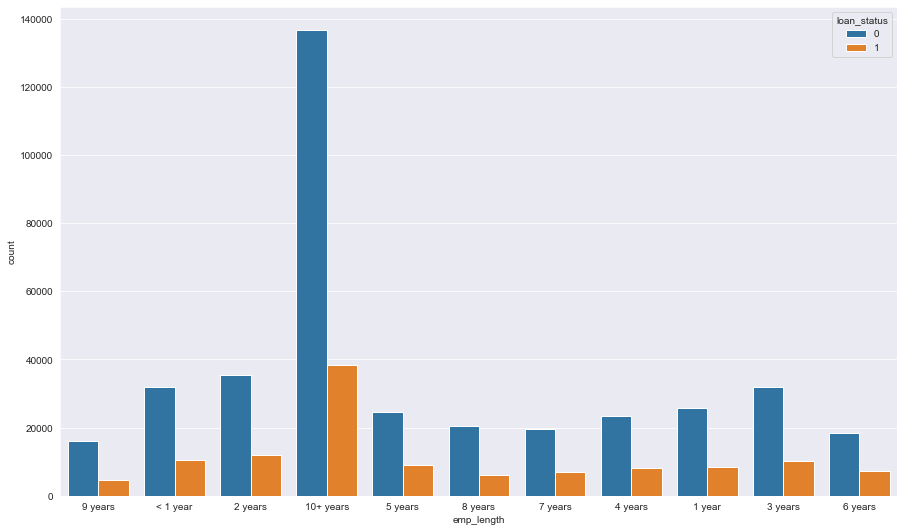

In [0]:
sns.countplot(data.emp_length,hue=data.loan_status)# checking relationships

Data mostly contain entries with more than 10 years of work exp, no clear pattern found with respect to loan status.

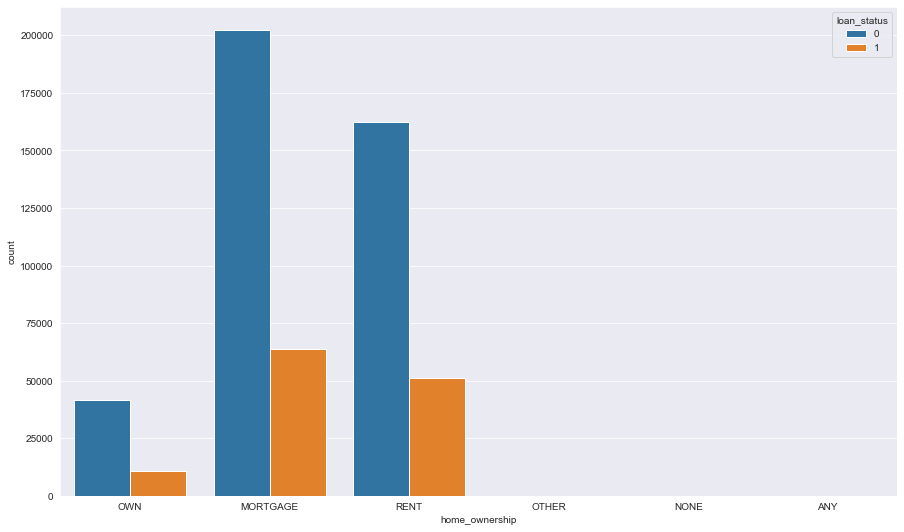

In [0]:
sns.countplot(data.home_ownership ,hue=data.loan_status)# checking relationships

Again no relationship found between house ownership and loan status.

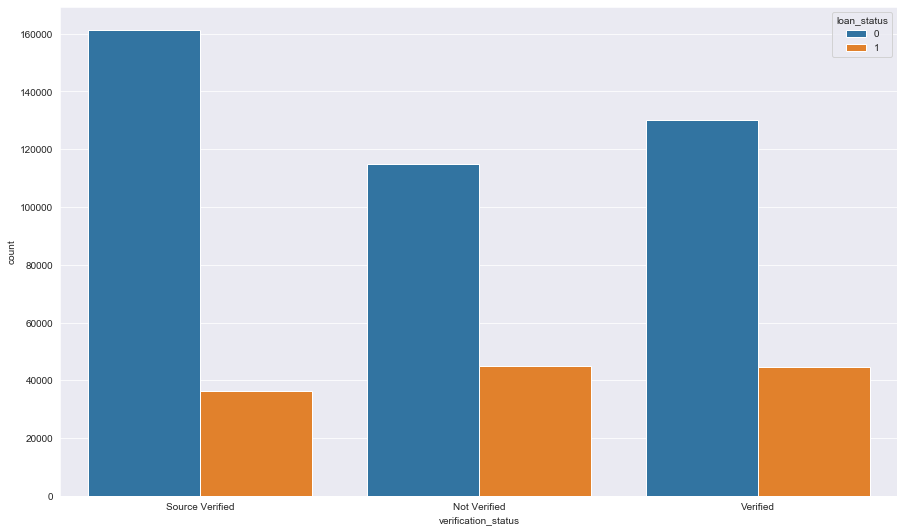

In [0]:
sns.countplot(data.verification_status,hue=data.loan_status)# checking relationships

Source Verified loans are less likley to default compared to "Not Verified" or "Verified".

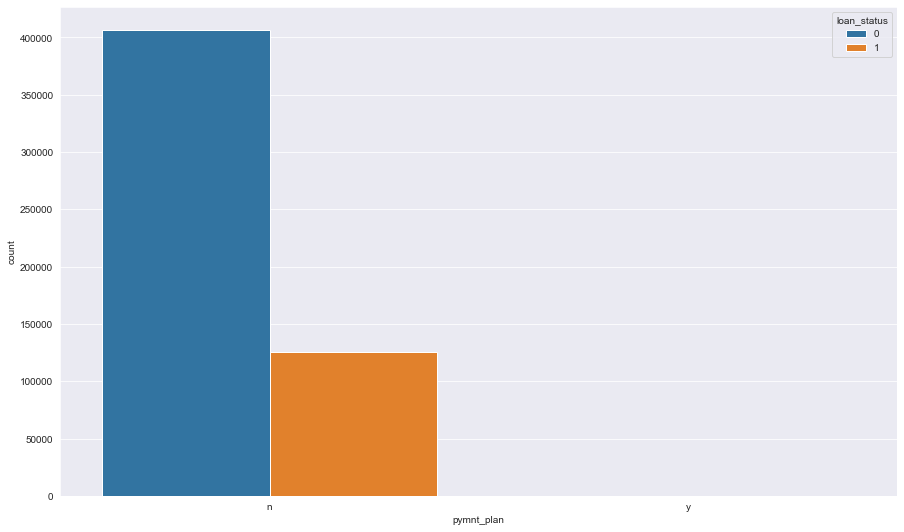

In [0]:
sns.countplot(data.pymnt_plan,hue=data.loan_status)# checking relationships

insignificant column as there are very low count of "y" to understand a pattern or make a assumtion.

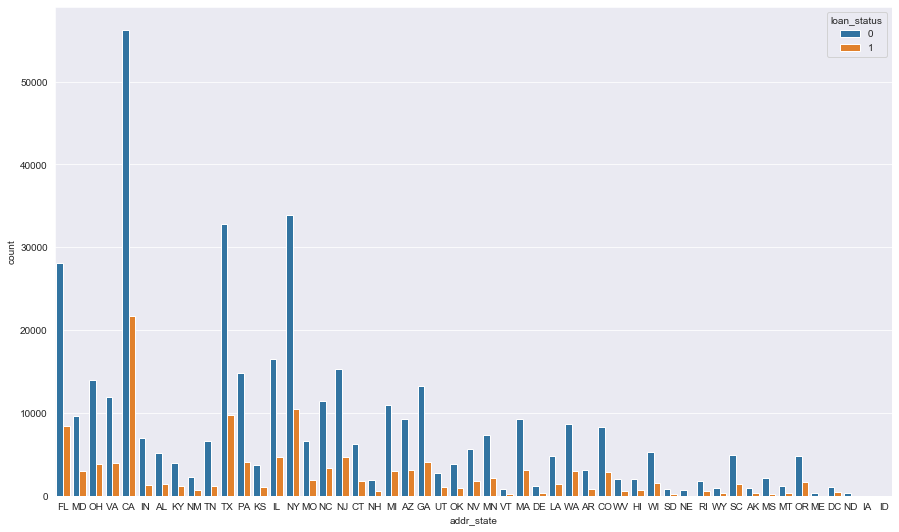

In [0]:
sns.countplot(data.addr_state,hue=data.loan_status)# checking relationships

as state and zipcode passes same info,hence deleting zipcode

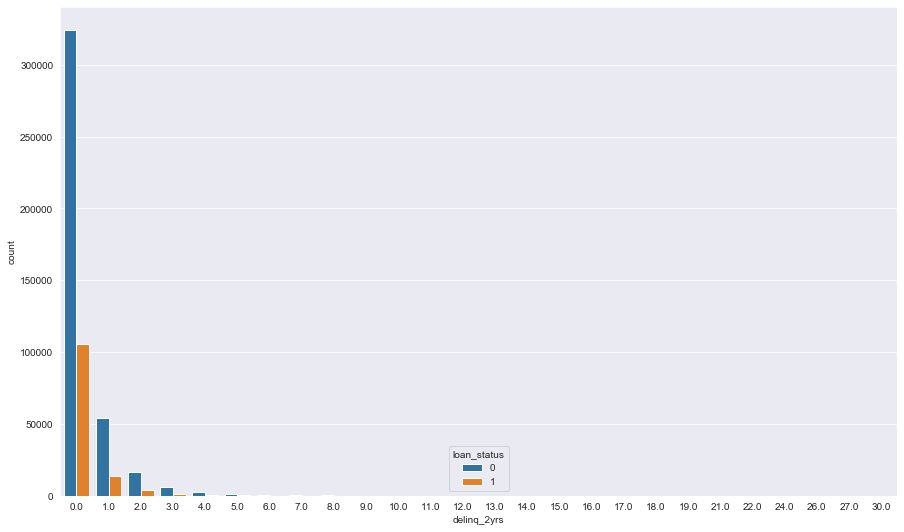

In [0]:
sns.countplot(data.delinq_2yrs,hue=data.loan_status)# checking relationships

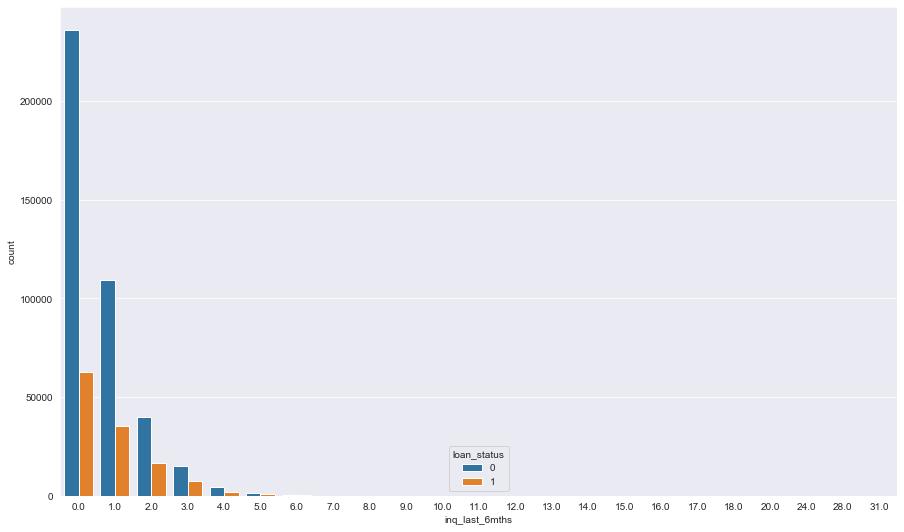

In [0]:
sns.countplot(data.inq_last_6mths,hue=data.loan_status)# checking relationships

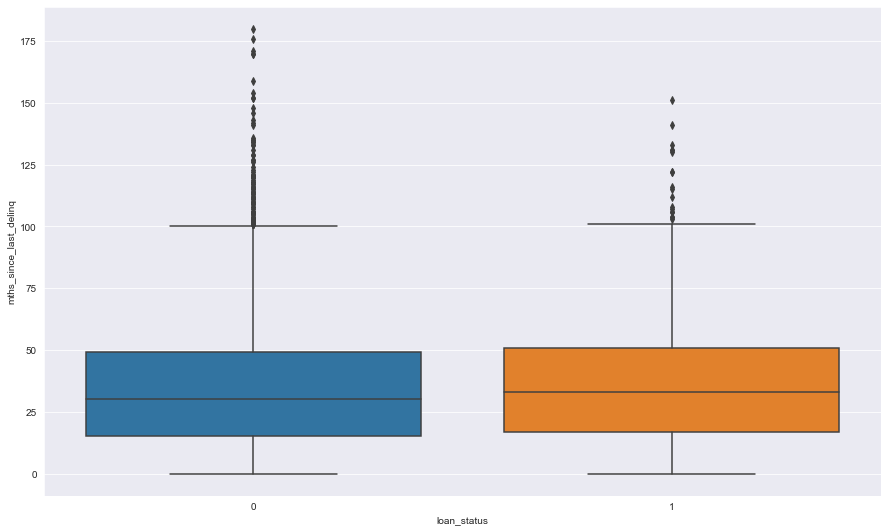

In [0]:
sns.boxplot(data.loan_status,data.mths_since_last_delinq)# checking relationships

In [0]:
def last_week_pay(x):
    l=x.split("t")
    return l[0]

In [0]:
data["last_week_pay"]=data.last_week_pay.apply(last_week_pay)#Cleaning the columns

In [0]:
def emp_length(x):
    if type(x)!=float:
        l=x.split(" ")
        for i in l:
            if i.isdigit()==True:
                return int(i)
            elif len(i)==3:
                return 10
    else:
        return x

In [0]:
data["emp_length"]=data.emp_length.apply(emp_length)#Cleaning the columns

In [0]:
def term(x):
    l=x.split(" ")
    return l[0]

In [0]:
data["term"]=data.term.apply(term)#Cleaning the columns

In [0]:
data.loan_status[data.emp_length.isnull()==True].value_counts()/(22403+4488)

In [0]:
data[data.emp_length.isnull()==True]

assuming all null values of emp_length are of entries with no employment records as evident that emp_title is also null for same, hence we are imputing with 0.

In [0]:
data.emp_length.fillna(1,inplace=True)#impute with 1 as 1 indicates <1

In [0]:
data[data.annual_inc.isnull()==True]

as it is understood these guys are newly employed entries with annual income not calculated yet or verifed yet. hence imputing with annual inc of entries with less that 1 year emp_length.

In [0]:
data.annual_inc.fillna(data.groupby(by="emp_length").median()["annual_inc"][1.0],inplace=True)

In [0]:
data[data.delinq_2yrs.isnull()==True].head()

In [40]:
data.emp_length[data.delinq_2yrs.isnull()==True].median()

1.0

as majority of entries with nulls in delinq_2yrs are with emp_length less than 1yr, we can impute this null with 0

In [0]:
data.delinq_2yrs.fillna(-1,inplace=True)#For other missing values, I used -1. This was done to give them a level of their own.

In [0]:
data.inq_last_6mths.fillna(-1,inplace=True)# same number of nulls, Hence same concept

In [0]:
data.open_acc.fillna(-1,inplace=True)# same number of nulls, Hence same concept

In [0]:
data.pub_rec.fillna(-1,inplace=True)# same number of nulls, Hence same concept

In [0]:
data.total_acc.fillna(-1,inplace=True)# same number of nulls, Hence same concept

In [0]:
data.acc_now_delinq.fillna(-1,inplace=True)# same number of nulls, Hence same concept

In [0]:
data["mths_since_last_delinq"]=np.where(((data.delinq_2yrs==0)&(data.mths_since_last_delinq.isnull()==True)),24,data.mths_since_last_delinq)

Logical Imputation

if the number of 30+ days delinquency in past 2 years is 0 then number of months since last delinq has to be 24 months minimum, hence the imputation.

In [52]:
data[data.mths_since_last_delinq.isnull()==True].shape

(16, 45)

In [0]:
data["mths_since_last_delinq"]=np.where(((data.mths_since_last_delinq.isnull()==True)&(data.delinq_2yrs>0)),round((24/((data.delinq_2yrs)+1)),0),data.mths_since_last_delinq)

In [0]:
data.mths_since_last_delinq.fillna(-99,inplace=True)

In [0]:
data["mths_since_last_record"]=np.where((data.mths_since_last_record.isnull()==True),0,1)

logical Imputation

mths_since_last_delinq=24/(delinq_2yrs+1)  (Maximum number of months since last delinq with given number of 30+ days delinquency in past 2 years)

mths_since_last_record= 0==No,1==Yes.

In [0]:
data[data.revol_util.isnull()==True]

In [0]:
data.revol_util.fillna(-1,inplace=True)

In [0]:
data.collections_12_mths_ex_med.value_counts()# too many zeros, hence deleting the column.

In [0]:
data.tot_coll_amt.fillna(-1,inplace=True)
data.tot_cur_bal.fillna(-1,inplace=True)
data.total_rev_hi_lim.fillna(-1,inplace=True)

In [0]:
data.zip_code.value_counts().count()

In [60]:
data.verification_status_joint.value_counts()

Not Verified       170
Verified           102
Source Verified     33
Name: verification_status_joint, dtype: int64

In [0]:
data.isnull().sum()

In [0]:
data.drop(columns="member_id",inplace=True)# Not Required
data.drop(columns="batch_enrolled",inplace=True)# Not Required as its same as member id
data.drop(columns="desc",inplace=True)# too many null values
data.drop(columns="mths_since_last_major_derog",inplace=True)# too many null values
data.drop(columns="verification_status_joint",inplace=True)# too many null values
data.drop(columns="pymnt_plan",inplace=True)# discussed above
data.drop(columns="collections_12_mths_ex_med",inplace=True)# discussed above

In [0]:
data.isnull().sum()

In [0]:
data.drop(columns="emp_title",inplace=True)

In [0]:
def clean_title(raw):
    if ('debt' in raw) or ('consol' in raw) or ('lidation' in raw):
        return 'debt consolidation'
    elif ('credit' in raw) or ('card' in raw):
        return 'credit card'
    elif 'wedd' in raw or 'marr' in raw:
        return 'wedding'
    elif 'home' in raw or 'house' in raw or 'bath' in raw:
        return 'home'
    elif ('car' in raw) or ('motor' in raw) or ('truck' in raw) or ('auto') in raw:
        return 'vehicle'
    elif ('payoff' in raw) or ('off' in raw) :
        return 'payoff'
    elif 'freedom' in raw:
        return 'freedom'
    elif 'pool' in raw:
        return 'pool'
    elif 'persona' in raw :
        return 'personal'
    elif 'vacation' in raw:
        return 'vacation'
    elif 'hosp' in raw or 'med' in raw:
        return 'medical'
    elif 'loan' in raw:
        return 'some loan'
    elif 'movin' in raw:
        return 'moving'
    else :
        return raw

In [0]:
data['title'] = data.title.apply(lambda x : x.lower() if type(x) == str else '')
data['title'] = data.title.apply(clean_title)

In [0]:
title_list = data.title.values

from collections import Counter
wordsDict = Counter(title_list)
wordsDictSorted = wordsDict.most_common()
wordsDictSorted = dict(wordsDictSorted)

title_list = []
for i in wordsDictSorted:
    if wordsDictSorted[i] > 1:
        title_list.append(i)
    else :
        break

In [0]:
def final_title(raw):
    if raw in title_list:
        return raw
    else :
        return 'Other 2'
data['title'] = data.title.apply(final_title)

In [0]:
data["term"]=pd.to_numeric(data.term)

In [0]:
data["emp_length"]=pd.to_numeric(data.emp_length)

In [0]:
data.last_week_pay=np.where((data.last_week_pay=="NA"),-1,data.last_week_pay)

In [0]:
data["last_week_pay"]=pd.to_numeric(data.last_week_pay)

In [0]:
data.groupby(by=["sub_grade","loan_status"]).median()

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
le=LabelEncoder()

In [0]:
data.info()

In [0]:
cat_cols=list(data.columns[data.dtypes == 'object'])

In [0]:
for i in cat_cols:
  data[i]=le.fit_transform(data[i])

In [0]:
data.shape

### **New** **Features**

In [0]:
value = -9999

def helping_features(value):
    data['Interest'] = data['funded_amnt']*data['int_rate']*data['term']/(100*12)
    if value == -9999:
        data['Monthly_income'] = data['annual_inc'].apply(lambda x : x/12 if x >=0 else -9999)
        data['Monthly_debt_repay'] = data['Monthly_income'] * data['dti']/100
        data['Monthly_debt_repay'] = data['Monthly_debt_repay'].apply(lambda x : x if x>0 else -9999) 
    else :
        data['Monthly_income'] = data['annual_inc']/12
        data['Monthly_debt_repay'] = data['Monthly_income'] * data['dti']/100

In [0]:
helping_features(-9999)

In [0]:
data.head()

In [0]:
data['unpaid_perc'] = (data['Interest'] - data['total_rec_int'])/data['Interest']

In [0]:
data['last_to_term'] = data['last_week_pay']/(data['term']*52/12)

In [0]:
data.total_rev_hi_lim[data.total_rev_hi_lim==0]=-1

In [0]:
data['monthly_int_to_debt_repay'] = data['Interest']/data['Monthly_debt_repay']/12
data['iti'] = data['Interest']/data['Monthly_income']/12
data['dti_and_iti'] = data['iti'] + data['dti']
data['dtc'] = data['Monthly_debt_repay']/data['total_rev_hi_lim']/12
data['itc'] = data['Interest']/data['total_rev_hi_lim']/(12*12)

In [0]:
data.head()

In [0]:
data.corr()

In [100]:
data.isnull().sum().sum()

0

In [0]:
data.info()

### **Model** **Building**

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import Imputer
import warnings
warnings.filterwarnings("ignore")

In [0]:
x=data.drop(columns="loan_status")
y=data.loan_status

In [0]:
model1=LogisticRegression( n_jobs=-1)

In [0]:
model2=RandomForestClassifier(n_estimators=100,criterion='gini', n_jobs=-1)

In [0]:
model3=LGBMClassifier(boosting_type='goss',learning_rate=0.1,objective="binary",n_estimators=100)

In [0]:
model4=XGBClassifier(booster='gbtree',learning_rate=0.1,n_estimators=500,max_depth=10)

In [129]:
for model,name in zip([model4],["XGBM"]):
    error=[]
    kfold=KFold(shuffle=True,n_splits=5,random_state=0)
    error=cross_val_score(model,x,y,scoring='roc_auc',cv=kfold)
    print("ROC_AUC:",np.mean(error),"VAR:",np.std(error,ddof=1),name)

ROC_AUC: 0.9756952904252424 VAR: 0.000981657221001024 XGBM


ROC_AUC: 0.7387347930182386 VAR: 0.01096134475748502 LR

ROC_AUC: 0.8694256550681105 VAR: 0.0017657837509172864 RF(n_estimators=100,criterion='gini', n_jobs=-1)

ROC_AUC: 0.9259098678460674 VAR: 0.0009347618289493431 LGBM(boosting_type='goss',learning_rate=0.1,objective="binary",n_estimators=100)

ROC_AUC: 0.9756952904252424 VAR: 0.000981657221001024 XGBM(booster='gbtree',learning_rate=0.1,n_estimators=500,max_depth=10)

In [170]:
model4.fit(x,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
features=model4.feature_importances_

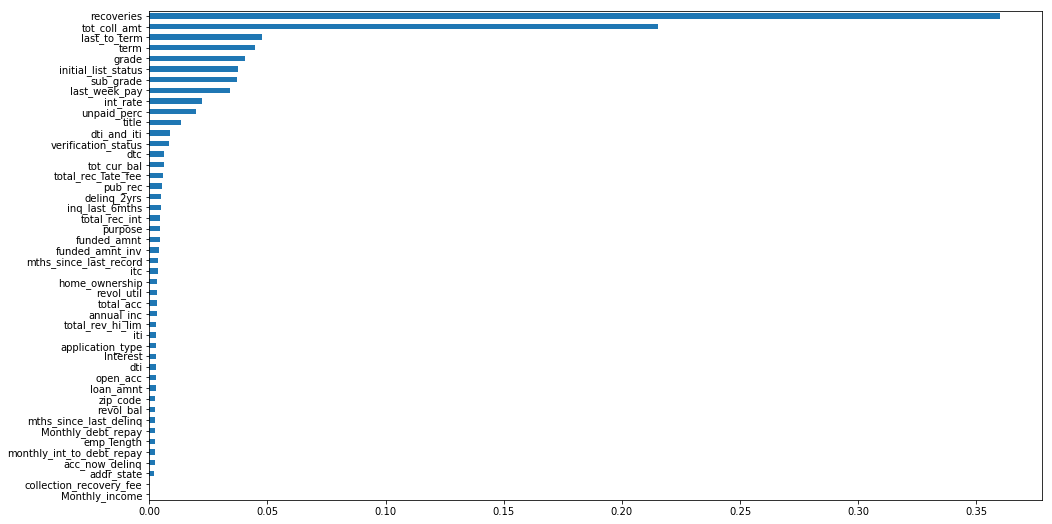

In [172]:
feat_importances = pd.Series(features, index=x.columns)
plt.figure(figsize=(16,9))
feat_importances.nsmallest(46).plot(kind='barh')

In [0]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30)

In [0]:
y_pred=model4.predict(x_test)

In [0]:
cm=confusion_matrix(y_test,y_pred)

In [189]:
print(cm)

[[120979   1235]
 [  3119  34396]]


In [190]:
cr=classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    122214
           1       0.97      0.92      0.94     37515

    accuracy                           0.97    159729
   macro avg       0.97      0.95      0.96    159729
weighted avg       0.97      0.97      0.97    159729



### Test DataSet

In [0]:
test=pd.read_csv("/content/drive/My Drive/My Projects/898ce544-0-MLChallenge_1Datac63af4e (1)/test_indessa.csv")

In [0]:
test.head()

In [0]:
test.isnull().sum()

Treating Nulls and Deleting columns

In [0]:
test.drop(columns="member_id",inplace=True)# Not Required
test.drop(columns="batch_enrolled",inplace=True)# Not Required as its same as member id
test.drop(columns="desc",inplace=True)# too many null values
test.drop(columns="mths_since_last_major_derog",inplace=True)# too many null values
test.drop(columns="verification_status_joint",inplace=True)# too many null values
test.drop(columns="pymnt_plan",inplace=True)# discussed above
test.drop(columns="collections_12_mths_ex_med",inplace=True)# discussed above
test.drop(columns="emp_title",inplace=True)

In [0]:
test['title'] = test.title.apply(lambda x : x.lower() if type(x) == str else '')
test['title'] = test.title.apply(clean_title)
title_list = test.title.values

from collections import Counter
wordsDict = Counter(title_list)
wordsDictSorted = wordsDict.most_common()
wordsDictSorted = dict(wordsDictSorted)

title_list = []
for i in wordsDictSorted:
    if wordsDictSorted[i] > 1:
        title_list.append(i)
    else :
        break

In [0]:
test['title'] = test.title.apply(final_title)

In [0]:
test["last_week_pay"]=test.last_week_pay.apply(last_week_pay)
test["emp_length"]=test.emp_length.apply(emp_length)#Cleaning the columns
test["term"]=test.term.apply(term)#Cleaning the columns
test.annual_inc.fillna(test.groupby(by="emp_length").median()["annual_inc"][1.0],inplace=True)
test.delinq_2yrs.fillna(-1,inplace=True)
test.inq_last_6mths.fillna(-1,inplace=True)
test.open_acc.fillna(-1,inplace=True)
test.pub_rec.fillna(-1,inplace=True)
test.total_acc.fillna(-1,inplace=True)
test.acc_now_delinq.fillna(-1,inplace=True)
test["mths_since_last_delinq"]=np.where(((test.delinq_2yrs==0)&(test.mths_since_last_delinq.isnull()==True)),24,test.mths_since_last_delinq)
test["mths_since_last_delinq"]=np.where(((test.mths_since_last_delinq.isnull()==True)&(test.delinq_2yrs>0)),round((24/((test.delinq_2yrs)+1)),0),test.mths_since_last_delinq)
test.mths_since_last_delinq.fillna(-99,inplace=True)
test["mths_since_last_record"]=np.where((test.mths_since_last_record.isnull()==True),0,1)
test.revol_util.fillna(-1,inplace=True)
test.tot_coll_amt.fillna(-1,inplace=True)
test.tot_cur_bal.fillna(-1,inplace=True)
test.total_rev_hi_lim.fillna(-1,inplace=True)
test.emp_length.fillna(1,inplace=True)#impute with 1 as 1 indicates <1

New Features

In [0]:
value = -9999

def helping_features_test(value):
    test['Interest'] = test['funded_amnt']*test['int_rate']*test['term']/(100*12)
    if value == -9999:
        test['Monthly_income'] = test['annual_inc'].apply(lambda x : x/12 if x >=0 else -9999)
        test['Monthly_debt_repay'] = test['Monthly_income'] * test['dti']/100
        test['Monthly_debt_repay'] = test['Monthly_debt_repay'].apply(lambda x : x if x>0 else -9999) 
    else :
        test['Monthly_income'] = test['annual_inc']/12
        test['Monthly_debt_repay'] = test['Monthly_income'] * test['dti']/100

In [0]:
test["term"]=pd.to_numeric(test.term)
test["emp_length"]=pd.to_numeric(test.emp_length)
test.last_week_pay=np.where((test.last_week_pay=="NA"),-1,test.last_week_pay)
test["last_week_pay"]=pd.to_numeric(test.last_week_pay)

In [0]:
helping_features_test(-9999)
test['unpaid_perc'] = (test['Interest'] - test['total_rec_int'])/test['Interest']
test['last_to_term'] = test['last_week_pay']/(test['term']*52/12)
test.total_rev_hi_lim[test.total_rev_hi_lim==0]=-1

In [0]:
test['monthly_int_to_debt_repay'] = test['Interest']/test['Monthly_debt_repay']/12
test['iti'] = test['Interest']/test['Monthly_income']/12
test['dti_and_iti'] = test['iti'] + test['dti']
test['dtc'] = test['Monthly_debt_repay']/test['total_rev_hi_lim']/12
test['itc'] = test['Interest']/test['total_rev_hi_lim']/(12*12)

In [0]:
cat_cols_test=list(test.columns[test.dtypes == 'object'])
for i in cat_cols_test:
  test[i]=le.fit_transform(test[i])

In [169]:
print(test.shape,x.shape)

(354951, 46) (532428, 46)


In [0]:
sample_submission=pd.read_csv("/content/drive/My Drive/My Projects/898ce544-0-MLChallenge_1Datac63af4e (1)/sample_submission.csv")

In [176]:
sample_submission.head()

,member_id,loan_status
0,11937648,0.5
1,38983318,0.5
2,27999917,0.5
3,61514932,0.5
4,59622821,0.5


In [0]:
final_submission=pd.read_csv("/content/drive/My Drive/My Projects/898ce544-0-MLChallenge_1Datac63af4e (1)/test_indessa.csv")

In [0]:
final_submission=final_submission[["member_id"]]

In [0]:
final_submission["loan_status"]=model4.predict(test)

In [184]:
final_submission.head()

,member_id,loan_status
0,11937648,0
1,38983318,0
2,27999917,0
3,61514932,0
4,59622821,0


In [0]:
final_submission.to_csv("final_submission.csv")

## THE END